In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn import preprocessing
pd.options.display.max_columns=999

In [95]:
df_name='df_car_target_1.csv'
sub_name='sub_car_target_1.csv'
df=pd.read_csv(df_name)
folds_num=10
df.head()

,acceleration,cylinders,displacement,horsepower,id,model year,mpg,origin,weight,car0,car0_1
0,16.0,4,135.0,84.0,0,82,29.0,1,2525.0,22.144444,27.400000
1,14.0,4,89.0,71.0,3,79,31.9,2,1925.0,36.450000,34.133333
2,15.5,6,156.0,108.0,9,76,19.0,3,2930.0,30.130769,19.500000
3,14.5,4,90.0,75.0,11,74,28.0,1,2125.0,22.144444,27.000000
4,17.3,4,89.0,62.0,13,81,37.7,3,2050.0,30.130769,37.700000


In [96]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [97]:
train_df=df[df['mpg'].notnull()]
test_df=df[df['mpg'].isnull()]
feats=[f for f in train_df.columns if f not in ['id','mpg']]

In [98]:
score=np.empty(folds_num)
feature_importance_df = pd.DataFrame()
folds=KFold(n_splits=folds_num,shuffle=True,random_state=0)
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats],train_df['mpg'])):
    train_X,train_y=train_df[feats].iloc[train_idx],train_df['mpg'].iloc[train_idx]
    valid_X,valid_y=train_df[feats].iloc[valid_idx],train_df['mpg'].iloc[valid_idx]
    
    gbm_reg=lgb.LGBMRegressor(objective='regression',
                         num_leaves=31,
                         n_estimators=100)
    gbm_reg.fit(train_X,train_y,
               verbose=0)
    pred_y=gbm_reg.predict(valid_X)
    score[n_fold]=mean_absolute_error(pred_y,valid_y)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = gbm_reg.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
score.mean()

1.6374420198003428

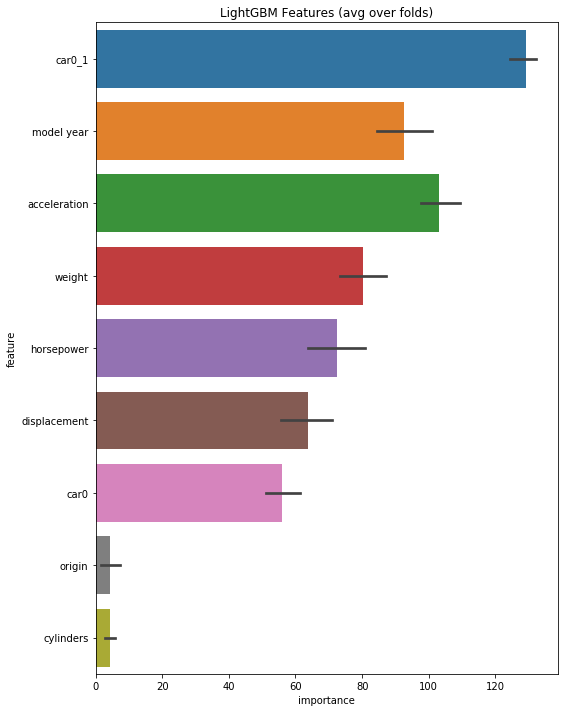

In [99]:
display_importances(feature_importance_df)

In [100]:
#submit
train_X,train_y=train_df[feats],train_df['mpg']
test_X=test_df[feats]
gbm_reg=lgb.LGBMRegressor(objective='regression',
                     num_leaves=31,
                     n_estimators=100)
gbm_reg.fit(train_X,train_y,
           verbose=0)
pred_sub=gbm_reg.predict(test_X)
sub=pd.DataFrame(test_df['id'])
sub['mpg']=pred_sub
sub.to_csv(sub_name,header=False,index=False)

199